In [45]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt # display figure inline in notebook
#import plotly.express as px # view the timeseries data in a slider
import seaborn as sns
#sns.set(rc={'figure.figsize':(8,5)}) # set the seaborn default figrue size
sns.set()
sns.set_style('white') #possible choices: white, dark, whitegrid, darkgrid, ticks
sns.set(rc={'figure.figsize':(8,5)}, style="white", font_scale=1.4)#style="whitegrid"
plt.rcParams["axes.labelsize"] = 12

from datetime import datetime # converting the timestamp data into datetime object
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # determining autocorrelation
from scipy import stats # detecting outliers by z score

In [19]:
SAVING_DIR = r'C:\Users\Rabbil\Documents\BDA_thesis\thesis-project\outputs\Vizualization'

DATA_PATH = r'C:\Users\Rabbil\Documents\BDA_thesis\thesis-project\data\processed\outlier_replace_processed_data.csv'
df = pd.read_csv(DATA_PATH)
df.head(4)

,date,group,spora-id,latitude,longitude,Pressure,Humidity,Temperature,NO_s,NO2_s,O3_s,CO_s,NO,NO2,O3,CO
0,2019-02-19 07:34:09,0.0,2,60.184558,24.922632,100259.0,27.889,30.55,0.025742,0.047203,0.033457,0.109408,0.023225,0.025169,0.011892,0.043826
1,2019-02-19 07:34:10,0.0,2,60.184562,24.922633,100259.0,27.886,30.56,0.025742,0.047203,0.033457,0.109408,0.023225,0.025169,0.011892,0.043826
2,2019-02-19 07:34:11,0.0,2,60.184563,24.922632,100260.0,27.876,30.56,0.025742,0.047203,0.033457,0.109408,0.023225,0.025169,0.011892,0.043826
3,2019-02-19 07:34:12,0.0,2,60.184563,24.922638,100261.0,27.876,30.57,0.025742,0.047203,0.033457,0.109408,0.023225,0.025169,0.011892,0.043826


In [20]:
df.shape

(6035760, 16)

In [21]:
# dropping few columns that are not necessary at this stage
df= df.drop(['group', 'spora-id', 'latitude', 'longitude'], axis=1)

In [23]:
# converting the timestamp data into datetime object 
df['date'] = pd.to_datetime(df['date'])

# setting index
df.set_index(['date'], inplace = True)

# resmaple to hourly frequency, aggregating with mean
df_by_hour = df.resample('H').mean()

print(df_by_hour.head())
print(df_by_hour.shape)

                          Pressure   Humidity  Temperature      NO_s  \
date                                                                   
2019-02-19 07:00:00  100256.183908  27.662287    30.718736  0.025742   
2019-02-19 08:00:00            NaN        NaN          NaN       NaN   
2019-02-19 09:00:00            NaN        NaN          NaN       NaN   
2019-02-19 10:00:00            NaN        NaN          NaN       NaN   
2019-02-19 11:00:00            NaN        NaN          NaN       NaN   

                        NO2_s      O3_s      CO_s        NO       NO2  \
date                                                                    
2019-02-19 07:00:00  0.047203  0.033457  0.109408  0.023225  0.025169   
2019-02-19 08:00:00       NaN       NaN       NaN       NaN       NaN   
2019-02-19 09:00:00       NaN       NaN       NaN       NaN       NaN   
2019-02-19 10:00:00       NaN       NaN       NaN       NaN       NaN   
2019-02-19 11:00:00       NaN       NaN       NaN       N

In [24]:
# filling the NaN value using ffill method
df_by_hour.fillna(method='ffill', inplace=True)

# Checking the number of null value
df_by_hour.isnull().sum()

Pressure       0
Humidity       0
Temperature    0
NO_s           0
NO2_s          0
O3_s           0
CO_s           0
NO             0
NO2            0
O3             0
CO             0
dtype: int64

## Feature Engineering
### Temporal feature engineering

In [28]:
# Feature engineering with timestamp data
# Extracting year, month and day information
# We can do it easily as DatetimeIndex has individual attributes for year, month, day etc

# Add columns with year, month, day and weeday name
df_by_hour['Hour'] = df_by_hour.index.hour
df_by_hour['Day_of_week'] = df_by_hour.index.dayofweek
df_by_hour['Day_of_month'] = df_by_hour.index.day
df_by_hour['Month'] = df_by_hour.index.month
df_by_hour['Day'] = df_by_hour.index.day_name()

# create the feature of 'is_weekday' from Day column
# Defining the day as weekday (1) or weekend (0)
filter1 = df_by_hour['Day']== 'Saturday'
filter2 = df_by_hour['Day']== 'Sunday'

df_by_hour['is_weekday']= np.where(filter1 | filter2, 0, 1)

df_by_hour.head(2)

,Pressure,Humidity,Temperature,NO_s,NO2_s,O3_s,CO_s,NO,NO2,O3,CO,Hour,Day_of_week,Day_of_month,Month,Day,is_weekday
date,,,,,,,,,,,,,,,,,
2019-02-19 07:00:00,100256.183908,27.662287,30.718736,0.025742,0.047203,0.033457,0.109408,0.023225,0.025169,0.011892,0.043826,7,1,19,2,Tuesday,1
2019-02-19 08:00:00,100256.183908,27.662287,30.718736,0.025742,0.047203,0.033457,0.109408,0.023225,0.025169,0.011892,0.043826,8,1,19,2,Tuesday,1


In [30]:
# let's see the value for Saturday and Sunday
#df_by_hour.query("Day=='Saturday' or Day =='Sunday'")

In [31]:
# Day part
# creating four groups of daypart on Hour column
# daypart function
def daypart(hour):
    if hour in [4,5,6,7,8,9]:
        return "Morning"
    elif hour in [10,11,12,13,14,15]:
        return "Noon"
    elif hour in [16,17,18,19,20,21]:
        return "Evening"
    else: return "Night"
# utilize it along with apply method
df_by_hour['daypart'] = df_by_hour.Hour.apply(daypart)

In [32]:
# converting categorical variable into numerical
# alternate option: train['city'] = train['city'].astype('category').cat.codes
df_by_hour['daypart'] = pd.factorize(df_by_hour.daypart)[0]

In [33]:
# creating season
def season(month):
    if month in [2,3,4]:
        return "Spring"
    else: return "Summer"
# utilize it along with apply method
df_by_hour['Season'] = df_by_hour.Month.apply(season)

In [35]:
# converting categorical variable into numerical
# alternate option: train['city'] = train['city'].astype('category').cat.codes
df_by_hour['Season'] = pd.factorize(df_by_hour.Season)[0]

# printing df
df_by_hour.tail(2)

,Pressure,Humidity,Temperature,NO_s,NO2_s,O3_s,CO_s,NO,NO2,O3,CO,Hour,Day_of_week,Day_of_month,Month,Day,is_weekday,daypart,Season
date,,,,,,,,,,,,,,,,,,,
2019-08-16 08:00:00,101307.645833,29.459542,36.976925,0.065928,0.000351,0.001295,0.087244,0.008205,0.002970,0.000202,0.034294,8,4,16,8,Friday,1,0,1
2019-08-16 09:00:00,101319.714286,29.695289,36.740334,0.065928,0.000351,0.001295,0.087244,0.007840,0.002752,0.000216,0.029159,9,4,16,8,Friday,1,0,1


#### Vizualizing the data after feature engineering
- Let's see how our feature engineering effort work, how well the new features separate the data

<AxesSubplot:xlabel='Month', ylabel='NO'>

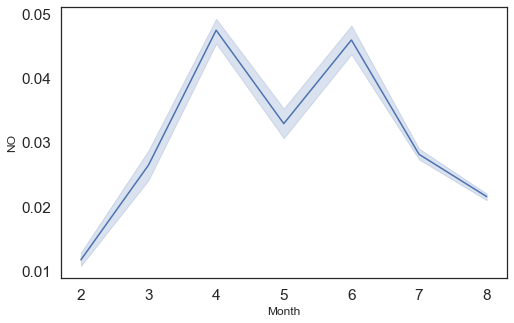

In [46]:
#df_by_month = df_by_hour.resample('M').mean()
#sns.lineplot(x=df_by_month.index, y='O3', data=df_by_month)

# Monthly pattern of data
sns.lineplot(x='Month', y='NO', data=df_by_hour.ffill())

<AxesSubplot:xlabel='Hour', ylabel='NO'>

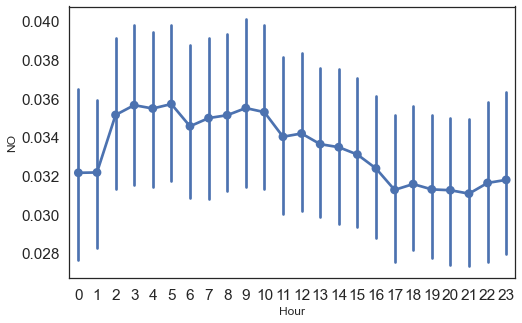

In [47]:
# Hourly pattern of data
sns.pointplot(x='Hour', y='NO', data=df_by_hour.ffill())

<AxesSubplot:xlabel='Day_of_week', ylabel='NO'>

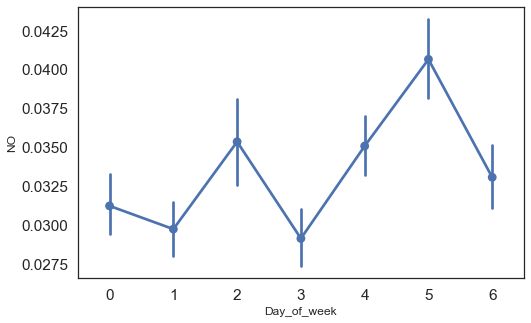

In [48]:
# Day of week pattern 
sns.pointplot(x='Day_of_week', y='NO', data=df_by_hour.ffill())

<AxesSubplot:xlabel='Hour', ylabel='NO'>

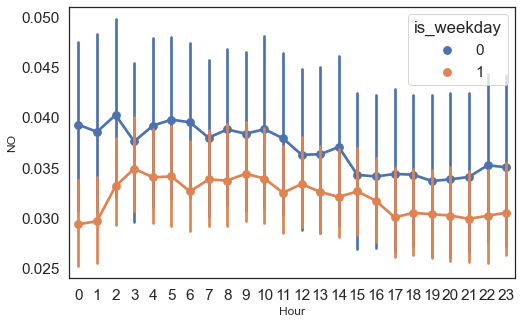

In [49]:
sns.pointplot(x='Hour', y='NO', data=df_by_hour.ffill(), hue='is_weekday')

<AxesSubplot:xlabel='Hour', ylabel='NO'>

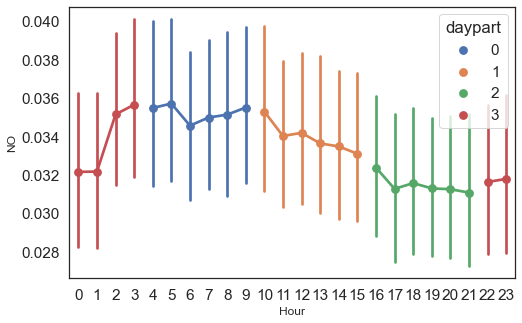

In [50]:
sns.pointplot(x='Hour', y='NO', data=df_by_hour.ffill(), hue='daypart')

<AxesSubplot:xlabel='Month', ylabel='NO'>

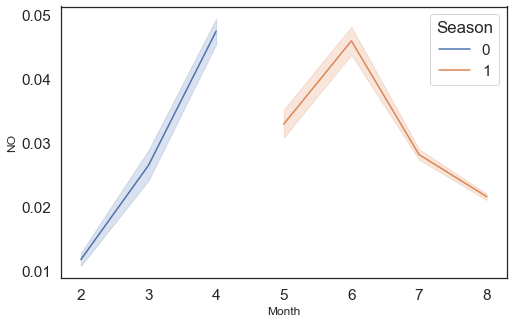

In [51]:
sns.lineplot(x='Month', y='NO', hue='Season', data=df_by_hour.ffill())

### Statistical feature engineering

In [53]:
# plot_acf is to idenfify parameter for moving average 
#plot_acf(df_by_hour.resample('D').mean().ffill().O3)# to identify the value of moving average
# we choosed 5 day rolling mean or 120 hour rolling mean
# however, for o3 it should be 10 days
#plt.savefig('autoC_O3.png')

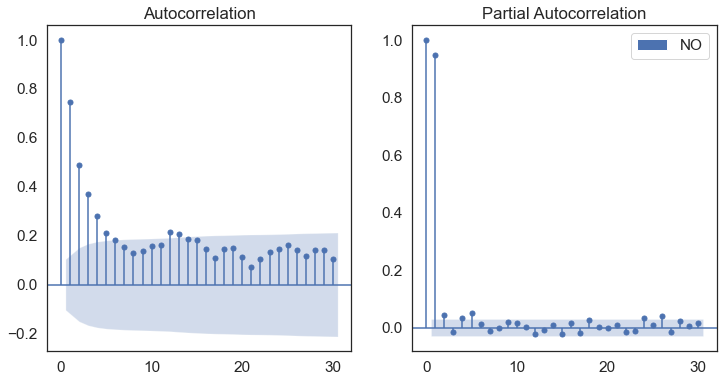

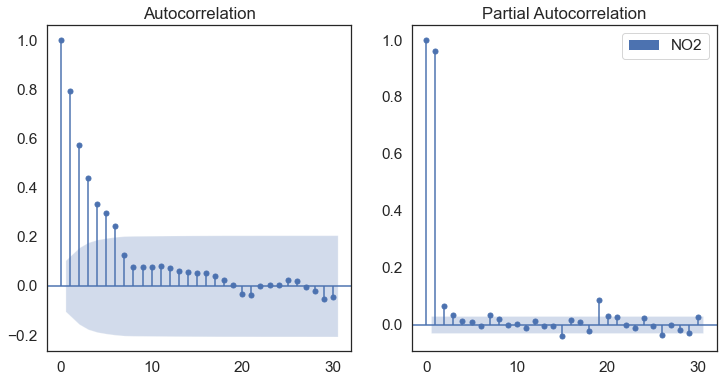

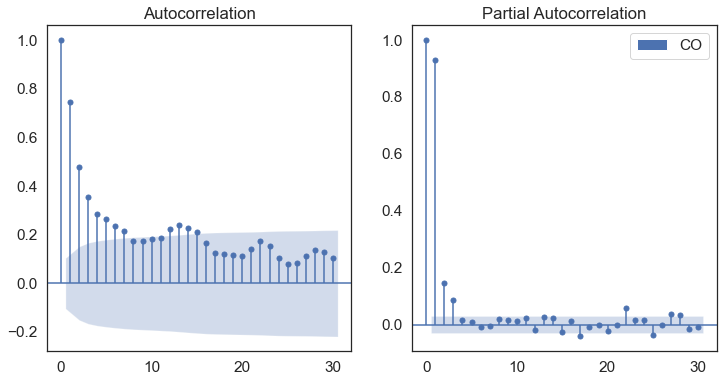

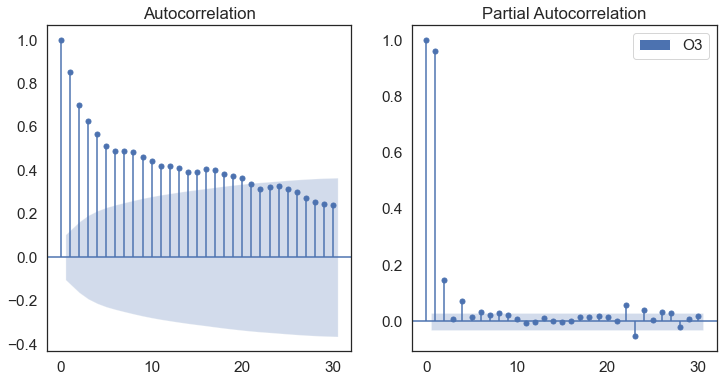

In [134]:
import statsmodels.api as sm
import matplotlib.patches as mpatches # for manually adding legend

def plot_acf_pacf(df,col1, label_name, file_name):
    fig, ax = plt.subplots(1,2, figsize=(12,6))
    #df = df_by_hour.copy()
    
    patch = mpatches.Patch(label=label_name)
    plt.legend(handles=[patch])  
    
    axes = sm.graphics.tsa.plot_acf(df[col1].resample('12H').mean().ffill(), lags=30, ax=ax[0])
    patch = mpatches.Patch(label=label_name)
    plt.legend(handles=[patch])  

    axes = sm.graphics.tsa.plot_pacf(df[col1].resample('H').mean().ffill(), lags=30,ax=ax[1])
    patch = mpatches.Patch(label=label_name)
    plt.legend(handles=[patch])  
    
    
    my_path = SAVING_DIR
    my_file = file_name
    plt.savefig(os.path.join(my_path, my_file))
    

plot_acf_pacf(df_by_hour,col1='NO', label_name='NO', file_name='NO_auto_partial_correlation.png')
plot_acf_pacf(df_by_hour,col1='NO2', label_name='NO2', file_name='NO2_auto_partial_correlation.png')
plot_acf_pacf(df_by_hour,col1='CO', label_name='CO', file_name='CO_auto_partial_correlation.png')
plot_acf_pacf(df_by_hour,col1='O3', label_name='O3', file_name='O3_auto_partial_correlation.png')

In [135]:
'''
# to identify the value of autoregression (lag number)
# we see that after 4 observation there is no corelation (which is in critical level) so we seletct order of 4 or 5 
# so we found the lag value differnece as 7 for NO, NO2, 8 for CO, 20 for o3 (x12) ;
# however that of pacf is 4 hours for all concentrati
'''

'\n# to identify the value of autoregression (lag number)\n# we see that after 4 observation there is no corelation (which is in critical level) so we seletct order of 4 or 5 \n# so we found the lag value differnece as 7 for NO, NO2, 8 for CO, 20 for o3 (x12) ;\n# however that of pacf is 4 hours for all concentrati\n'

In [138]:
# creating more feautres based on lagged value difference 
df_by_hour['NO_lag_feature']= df_by_hour.NO.shift(4)
df_by_hour['NO2_lag_feature']= df_by_hour.NO2.shift(4)
df_by_hour['CO_lag_feature']= df_by_hour.CO.shift(4)
df_by_hour['O3_lag_feature']= df_by_hour.O3.shift(4)

# creating more features based on rolling mean
df_by_hour['NO_rolling_mean']= df_by_hour.NO.rolling(window=84).mean()
df_by_hour['NO2_rolling_mean']= df_by_hour.NO2.rolling(window=84).mean()
df_by_hour['CO_rolling_mean']= df_by_hour.CO.rolling(window=96).mean()
df_by_hour['O3_rolling_mean']= df_by_hour.O3.rolling(window=240).mean()

# creating more features based on rolling min
df_by_hour['NO_rolling_min']= df_by_hour.NO.rolling(window=84).min()
df_by_hour['NO2_rolling_min']= df_by_hour.NO2.rolling(window=84).min()
df_by_hour['CO_rolling_min']= df_by_hour.CO.rolling(window=96).min()
df_by_hour['O3_rolling_min']= df_by_hour.O3.rolling(window=240).min()

# creating more features based on rolling max
df_by_hour['NO_rolling_max']= df_by_hour.NO.rolling(window=84).max()
df_by_hour['NO2_rolling_max']= df_by_hour.NO2.rolling(window=84).max()
df_by_hour['CO_rolling_max']= df_by_hour.CO.rolling(window=96).max()
df_by_hour['O3_rolling_max']= df_by_hour.O3.rolling(window=240).max()

# creating more features based on rolling deviation 
df_by_hour['NO_rolling_std']= df_by_hour.NO.rolling(window=84).std()
df_by_hour['NO2_rolling_std']= df_by_hour.NO2.rolling(window=84).std()
df_by_hour['CO_rolling_std']= df_by_hour.CO.rolling(window=96).std()
df_by_hour['O3_rolling_std']= df_by_hour.O3.rolling(window=240).std()

In [147]:
df_by_hour.isnull().sum()

Pressure              0
Humidity              0
Temperature           0
NO_s                  0
NO2_s                 0
O3_s                  0
CO_s                  0
NO                    0
NO2                   0
O3                    0
CO                    0
Hour                  0
Day_of_week           0
Day_of_month          0
Month                 0
Day                   0
is_weekday            0
daypart               0
Season                0
NO_lag_feature        4
NO2_lag_feature       4
CO_lag_feature        4
O3_lag_feature        4
NO_rolling_mean      83
NO2_rolling_mean     83
CO_rolling_mean      95
O3_rolling_mean     239
NO_rolling_min       83
NO2_rolling_min      83
CO_rolling_min       95
O3_rolling_min      239
NO_rolling_max       83
NO2_rolling_max      83
CO_rolling_max       95
O3_rolling_max      239
NO_rolling_std       83
NO2_rolling_std      83
CO_rolling_std       95
O3_rolling_std      239
dtype: int64

In [148]:
# we are now dropping the first rows with null value which is added after feature added
df_by_hour =df_by_hour.dropna()
# For filling with median
#df_by_hour = df_by_hour.fillna(df.median())
# for filling with zeros
#df_by_hour.fillna(0.00, index =True)
df_by_hour.head(2)

,Pressure,Humidity,Temperature,NO_s,NO2_s,O3_s,CO_s,NO,NO2,O3,...,CO_rolling_min,O3_rolling_min,NO_rolling_max,NO2_rolling_max,CO_rolling_max,O3_rolling_max,NO_rolling_std,NO2_rolling_std,CO_rolling_std,O3_rolling_std
date,,,,,,,,,,,,,,,,,,,,,
2019-03-01 06:00:00,100619.981389,19.921558,12.797778,0.070146,0.002855,0.059470,0.062104,0.010423,0.002472,0.000708,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010128,0.001182,0.017390,0.003126
2019-03-01 07:00:00,100585.411944,23.175349,9.847472,0.053864,0.002855,0.059185,0.029971,0.009536,0.002502,0.000517,...,0.029785,0.000218,0.079813,0.007066,0.195127,0.011892,0.010123,0.001187,0.017379,0.003055


In [152]:
#printing columns name
df_by_hour.columns

Index(['Pressure', 'Humidity', 'Temperature', 'NO_s', 'NO2_s', 'O3_s', 'CO_s',
       'NO', 'NO2', 'O3', 'CO', 'Hour', 'Day_of_week', 'Day_of_month', 'Month',
       'Day', 'is_weekday', 'daypart', 'Season', 'NO_lag_feature',
       'NO2_lag_feature', 'CO_lag_feature', 'O3_lag_feature',
       'NO_rolling_mean', 'NO2_rolling_mean', 'CO_rolling_mean',
       'O3_rolling_mean', 'NO_rolling_min', 'NO2_rolling_min',
       'CO_rolling_min', 'O3_rolling_min', 'NO_rolling_max', 'NO2_rolling_max',
       'CO_rolling_max', 'O3_rolling_max', 'NO_rolling_std', 'NO2_rolling_std',
       'CO_rolling_std', 'O3_rolling_std'],
      dtype='object')

### Feature selection

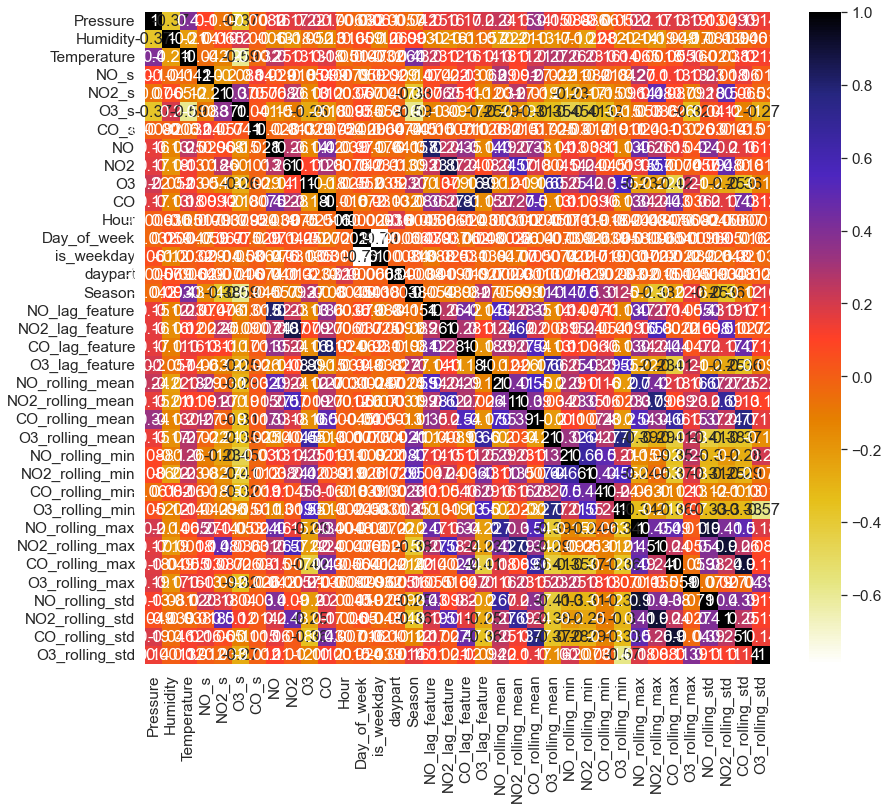

In [155]:
# Reference by Krish Naik- feature selection by correlation matrix
# Selection of feature based on Pearson's correlation analysis
# We will remove the highly correlated features (corelation among independent features)

def correlation_heatmap(df):
    
    plt.figure(figsize=(14,12))
    cor = df.drop(['Day_of_month', 'Month', 'Day'], axis=1).corr()
    svm =sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r) # family='Arial', fontsize=14
    figure= svm.get_figure()

    my_path = SAVING_DIR
    my_file = 'heatmap_correlation_matrix.png'
    figure.savefig(os.path.join(my_path, my_file))
    #figure.savefig('heatmap_correlation_matrix.png')
    #plt.show()


correlation_heatmap(df_by_hour)

In [156]:
# let's wirte a function for selecting highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set() # set of all names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in abosolute coeff value
                colname= corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
    return col_corr

In [160]:
corr_features = correlation(df_by_hour, 0.8)
print(len(set(corr_features)))
print(corr_features)

8
{'NO_rolling_std', 'NO2_lag_feature', 'Season', 'NO2_rolling_std', 'O3_lag_feature', 'CO_lag_feature', 'CO_rolling_std', 'NO_lag_feature'}


In [179]:
df_by_hour = df_by_hour.reset_index(drop=True)

In [184]:
# Saving the data
#df_by_hour.to_csv('C:/Users/Rabbil/Documents/BDA_thesis/Notebooks/cleaned_df_final.csv')

DIR_TO_SAVE = r'C:\Users\Rabbil\Documents\BDA_thesis\thesis-project\data\processed'
csv_file_name ='cleaned_df_final.csv'
csv_file_loc = os.path.join(DIR_TO_SAVE, csv_file_name)

# df to csv file
df_by_hour.to_csv(csv_file_loc, index = False)

data = pd.read_csv(r'C:\Users\Rabbil\Documents\BDA_thesis\thesis-project\data\processed\cleaned_df_final.csv').drop(['index'], axis=1)